In [31]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Q1. Downloading the data



In [3]:
pip install pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 19.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')

In [3]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [4]:
len(df.columns)

19

### Q2. Computing duration

In [5]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df['duration'] = df.duration.dt.total_seconds() / 60

In [6]:
df.duration.mean()

np.float64(15.668995167330449)

In [7]:
df.duration.std()

np.float64(42.59435124195457)

### Q3. Dropping outliers

In [8]:
len(df[(df.duration >= 1) & (df.duration <= 60)]) / len(df) * 100

98.1220282212598

In [9]:
df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

### Q4. One-hot encoding

In [10]:
categorical = ['PULocationID', 'DOLocationID']

In [11]:
df[categorical] = df[categorical].astype(str)

In [12]:
train_dicts = df[categorical].to_dict(orient='records')

In [13]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [14]:
print(f'Feature matrix size: {X_train.shape}')

Feature matrix size: (3009173, 515)


### Q5. Training a model

In [15]:
target = 'duration'
y_train = df[target].values

In [32]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

In [33]:
print(f'Train MSE: {mean_squared_error(y_train, y_pred)}')
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f'Train RMSE: {rmse}')

Train MSE: 58.5112080402573
Train RMSE: 7.649261927810898


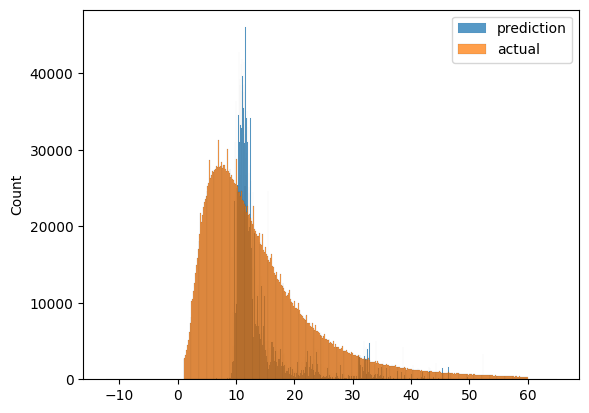

In [34]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend();

### Q6. Evaluating the model

In [37]:
categorical = ['PULocationID', 'DOLocationID']

def read_data(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].astype('str')
    
    return df

In [38]:
df_val = read_data('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

In [39]:
val_dicts = df_val[categorical].to_dict(orient='records')

In [40]:
X_val = dv.transform(val_dicts) 
y_val = df_val.duration.values

In [41]:
y_pred = lr.predict(X_val)

In [42]:
print(f'Val RMSE: {mean_squared_error(y_val, y_pred)}')
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'Train RMSE: {rmse}')

Val RMSE: 61.024498179501414
Train RMSE: 7.811817853707383
